In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!cat /proc/meminfo

MemTotal:       13335192 kB
MemFree:         2318024 kB
MemAvailable:   12321072 kB
Buffers:          165668 kB
Cached:          9806544 kB
SwapCached:            0 kB
Active:           732832 kB
Inactive:        9564064 kB
Active(anon):     369104 kB
Inactive(anon):   187852 kB
Active(file):     363728 kB
Inactive(file):  9376212 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1032 kB
Writeback:             0 kB
AnonPages:        324720 kB
Mapped:           145768 kB
Shmem:            254972 kB
Slab:             627340 kB
SReclaimable:     589248 kB
SUnreclaim:        38092 kB
KernelStack:        3632 kB
PageTables:         4860 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667596 kB
Committed_AS:    1991396 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:      2048 kB
ShmemHugePages:  

In [3]:
!pip3 install torch torchvision
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# !pip3 install --no-cache-dir -I pillow

    100% |████████████████████████████████| 519.5MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a2ca000 @  0x7f48a9f591c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.0MB/s 
    100% |████████████████████████████████| 2.0MB 2.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import os
os.chdir("drive/Collab/deep_dream_pytorch")

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import scipy.misc
import json
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


## Helper Functions: 
- These will be used again and again

In [0]:
def preprocess(image, x=True):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
#   image = np.transpose(image, (2,0,1))
  transform = transforms.Compose([  transforms.ToPILImage(),
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    normalize
  ])
  image = transform(image)
  if x is True:
    image = Variable(image.unsqueeze(0).cuda())
  return image

def predict(image):
  data = model(image).data[0]
  _, index = data.max(0)

  
#   print(index.item())
  return str(index.item()), labels[str(index.item())][1]

def postprocess(image):
  return image * torch.Tensor([0.229, 0.224, 0.225]).cuda() + torch.Tensor([0.485,0.456,0.406]).cuda()

def load_image(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   image = image/[255.,255.,255.]
  axis('off')
  imshow(image)
  return image

def gray(image):
  return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

- Load your desired Image

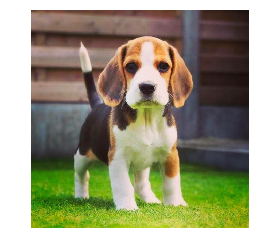

In [37]:
dog = load_image('beagle.jpg')

- Load the desired Model, in this case VGG16 

**Note** : Do try Inception, It's the best for visualization research

In [7]:
model = models.vgg16(pretrained=True)
model = model.cuda()
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /content/.torch/models/vgg16-397923af.pth
90.1%

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

- Loading Imagenet Labels

In [0]:
with open('imagenet_class_index.json') as labels:
  labels = json.load(labels)

In [0]:
dog = preprocess(dog)

In [47]:
print(predict(dog))

('162', 'beagle')


In [0]:
modules = list(model.features.modules())

In [0]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    shape = image.shape[0]
    image = torch.sum(image, dim=0, keepdim=True)
    image = torch.div(image, shape)
#     print(shape)
    return image

## Code for Total Activations of Each Layer#

In [0]:
#Layer Activations:

def activations(image):
  outputs = []
  names = []
  out_im = []
  for layer in modules[1:]:
#     print(layer, image.shape)
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
    
  for i in outputs:
    i = i.squeeze(0)
#     print(i.size())
    grayscale = to_grayscale(i).squeeze(0)
    i = grayscale.data.cpu().numpy()
#     print(i.shape)
    out_im.append(i)
    
  fig = figure()
  rcParams["figure.figsize"]=(30,50)
  
  for i in range(len(out_im)):
#     print(out_im[i].shape)
    
    a = fig.add_subplot(8,4,i+1)
#     img = np.transpose(out_im[i],(1,2,0))
#     print(img.shape)
    imshow(1-out_im[i])
    axis('off')
    a.set_title(names[i].partition('(')[0], fontsize=30)
    

>>>>>> ## Total Activations of Each Layer





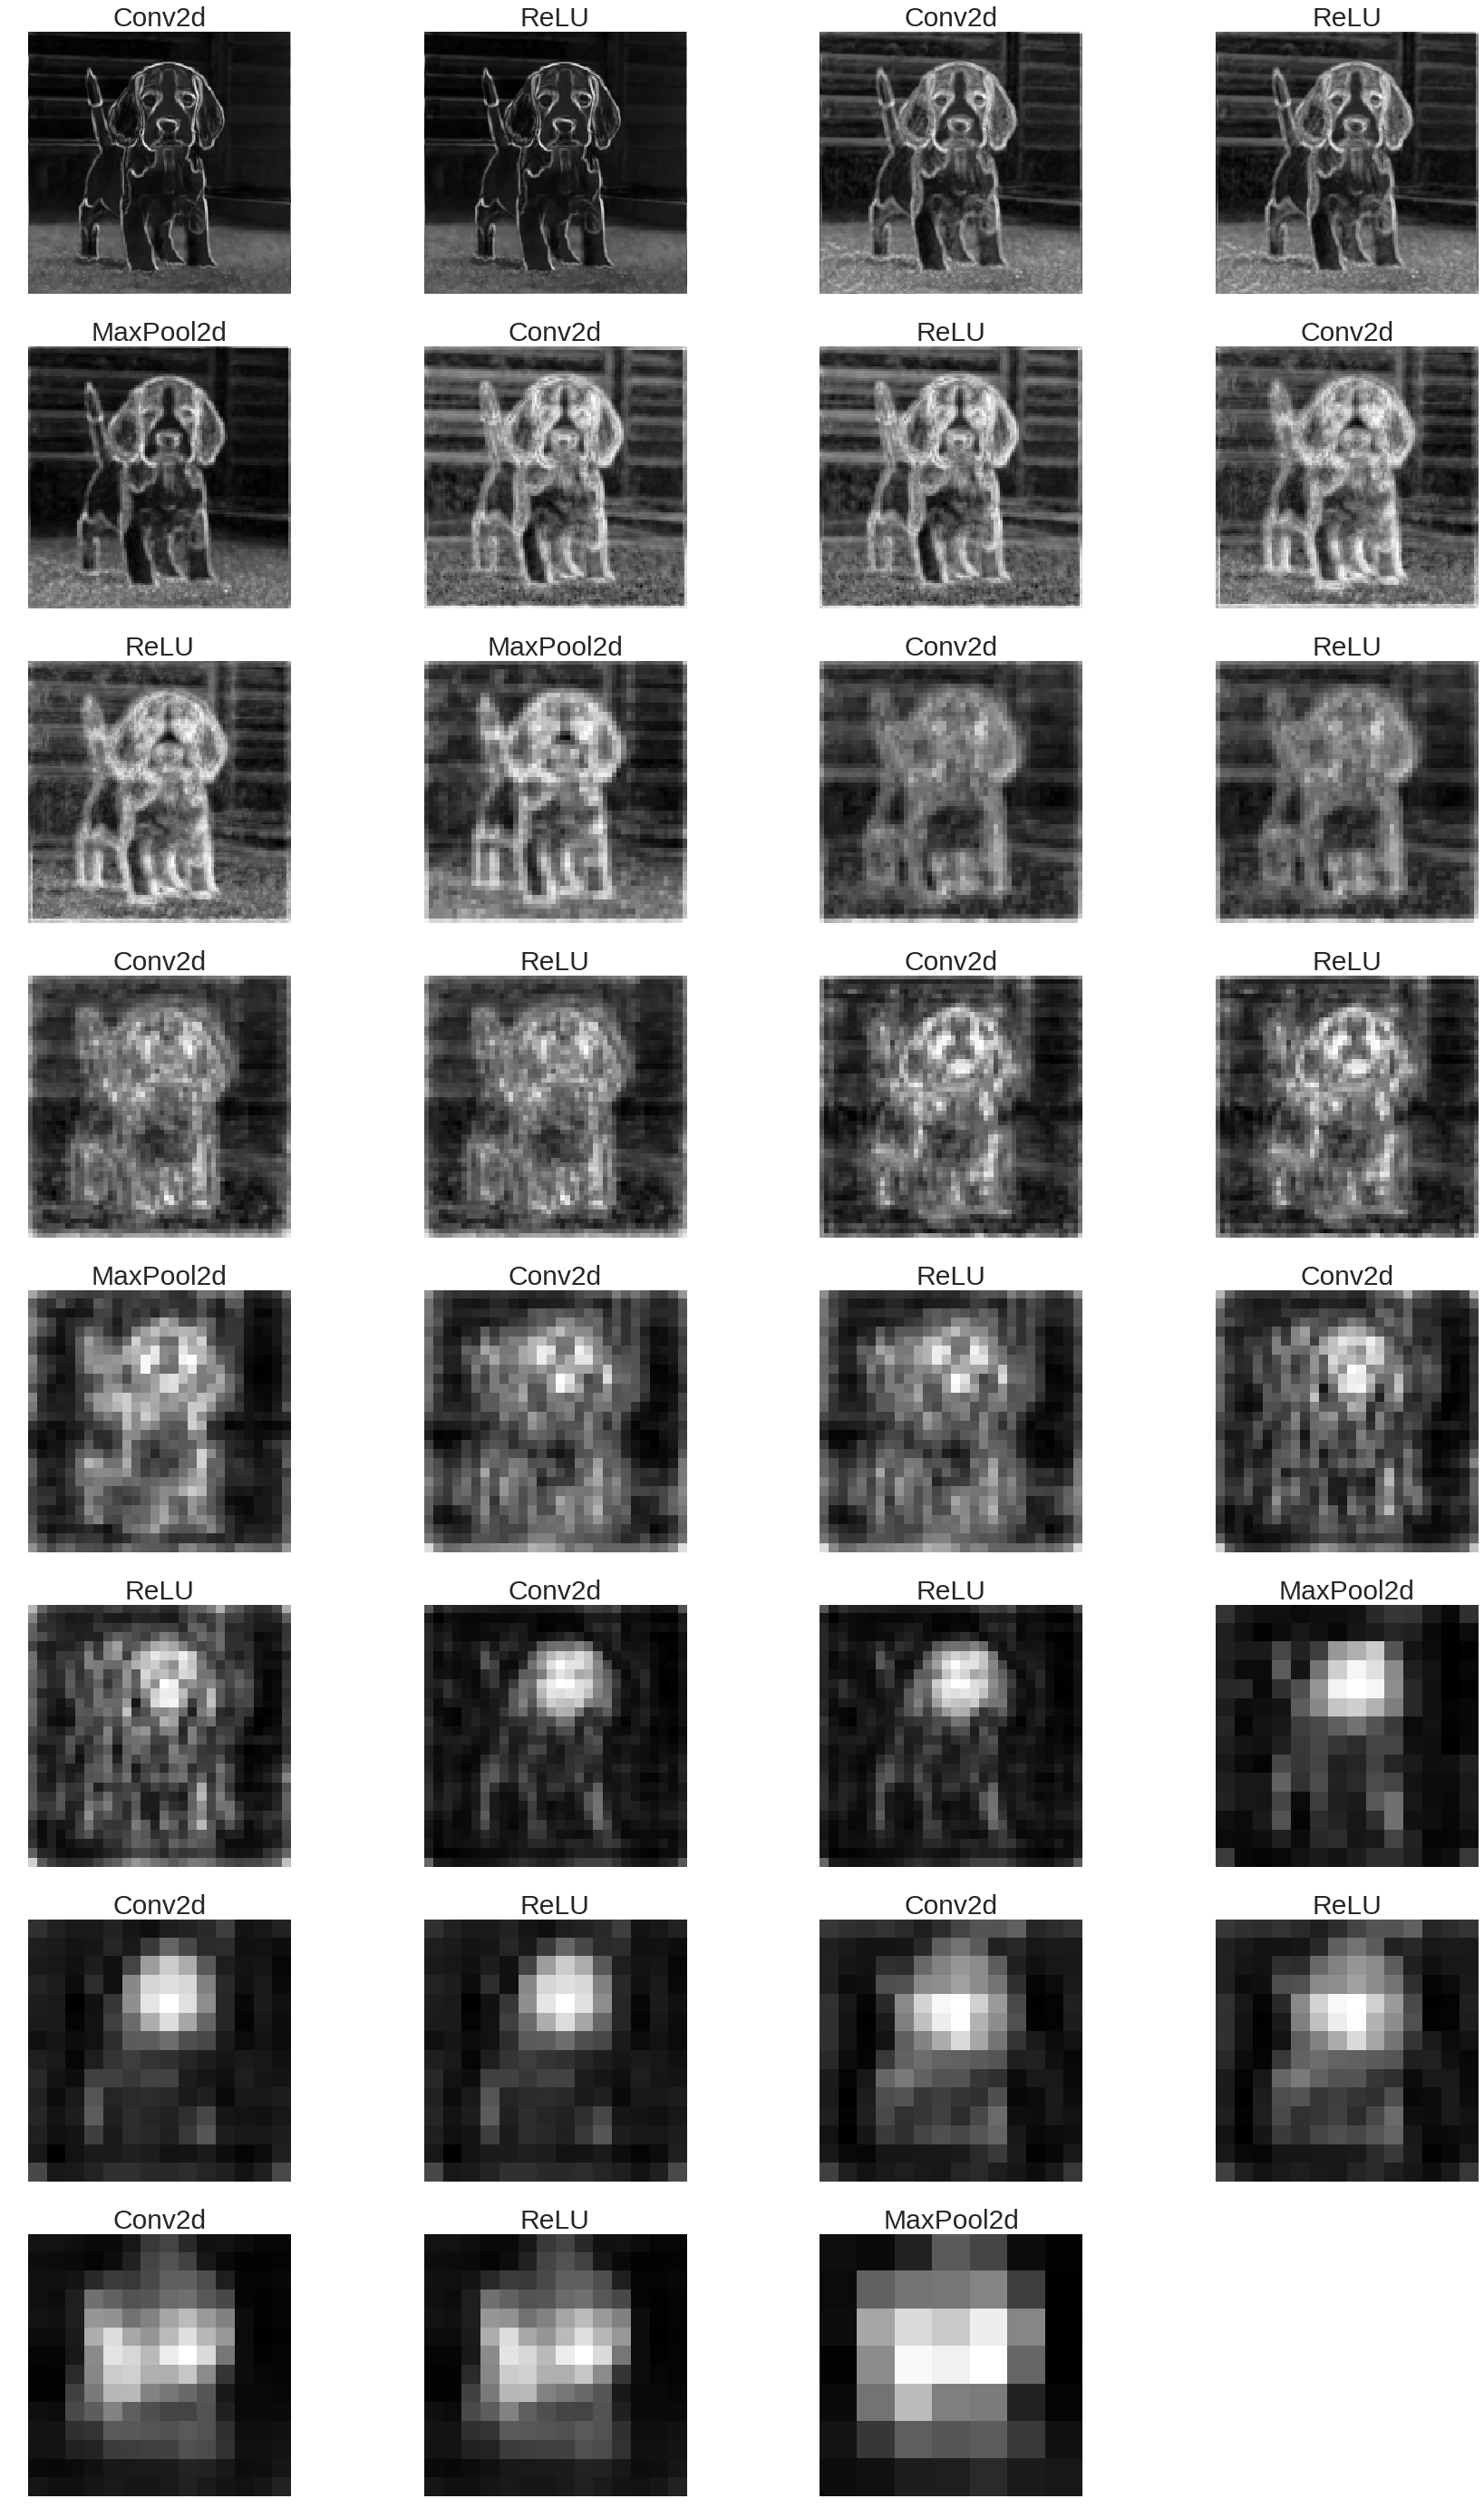

In [143]:
# print(dog.shape)
activations(dog)

## Observations:
- ReLU does not show any noticable effects. Can they be removed at test time?
- While it seems MaxPool is great for earlier layers, but should not be used in later layers, it's actually opposite, since information loss in the activation region corresponds to information gain in the feature/weight region.
- Thus while it seems that using maxpool in earlier layers only removes redundant features, the case is that in the weight region, it's the final layer weights that are redundant rather than the earlier ones.
- Although activations are getting gross and non-interpretable, weights/neurons/detectors are getting more and more specific.
- For an all conv network, the final activations in the last layer should correspond to the sum of all the class-specific occlusion maps.

## Code for per filter Activations

In [0]:
def filter_activations(image, chosen_layer): #Choose a layer to show activation of each of its filter seperately
  if chosen_layer < 0:
    chosen_layer +=31
  output = None
  name = None
  for cnt, layer in enumerate(modules[1:]):
    image = layer(image)
    
    if cnt == chosen_layer:
      output = image
      name = str(layer)
  
  filters = []
  output = output.data.squeeze()
  
  for i in range(output.shape[0]):
    filters.append(output[i,:,:])
   
  fig = figure()
  rcParams["figure.figsize"]=(30,50)
  title(name,fontsize=30)
  for i in range(len(filters)):
    a = fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
    imshow(1-filters[i])
    plt.axis('off')
  
  

## Per filter activations of a Chosen Layer

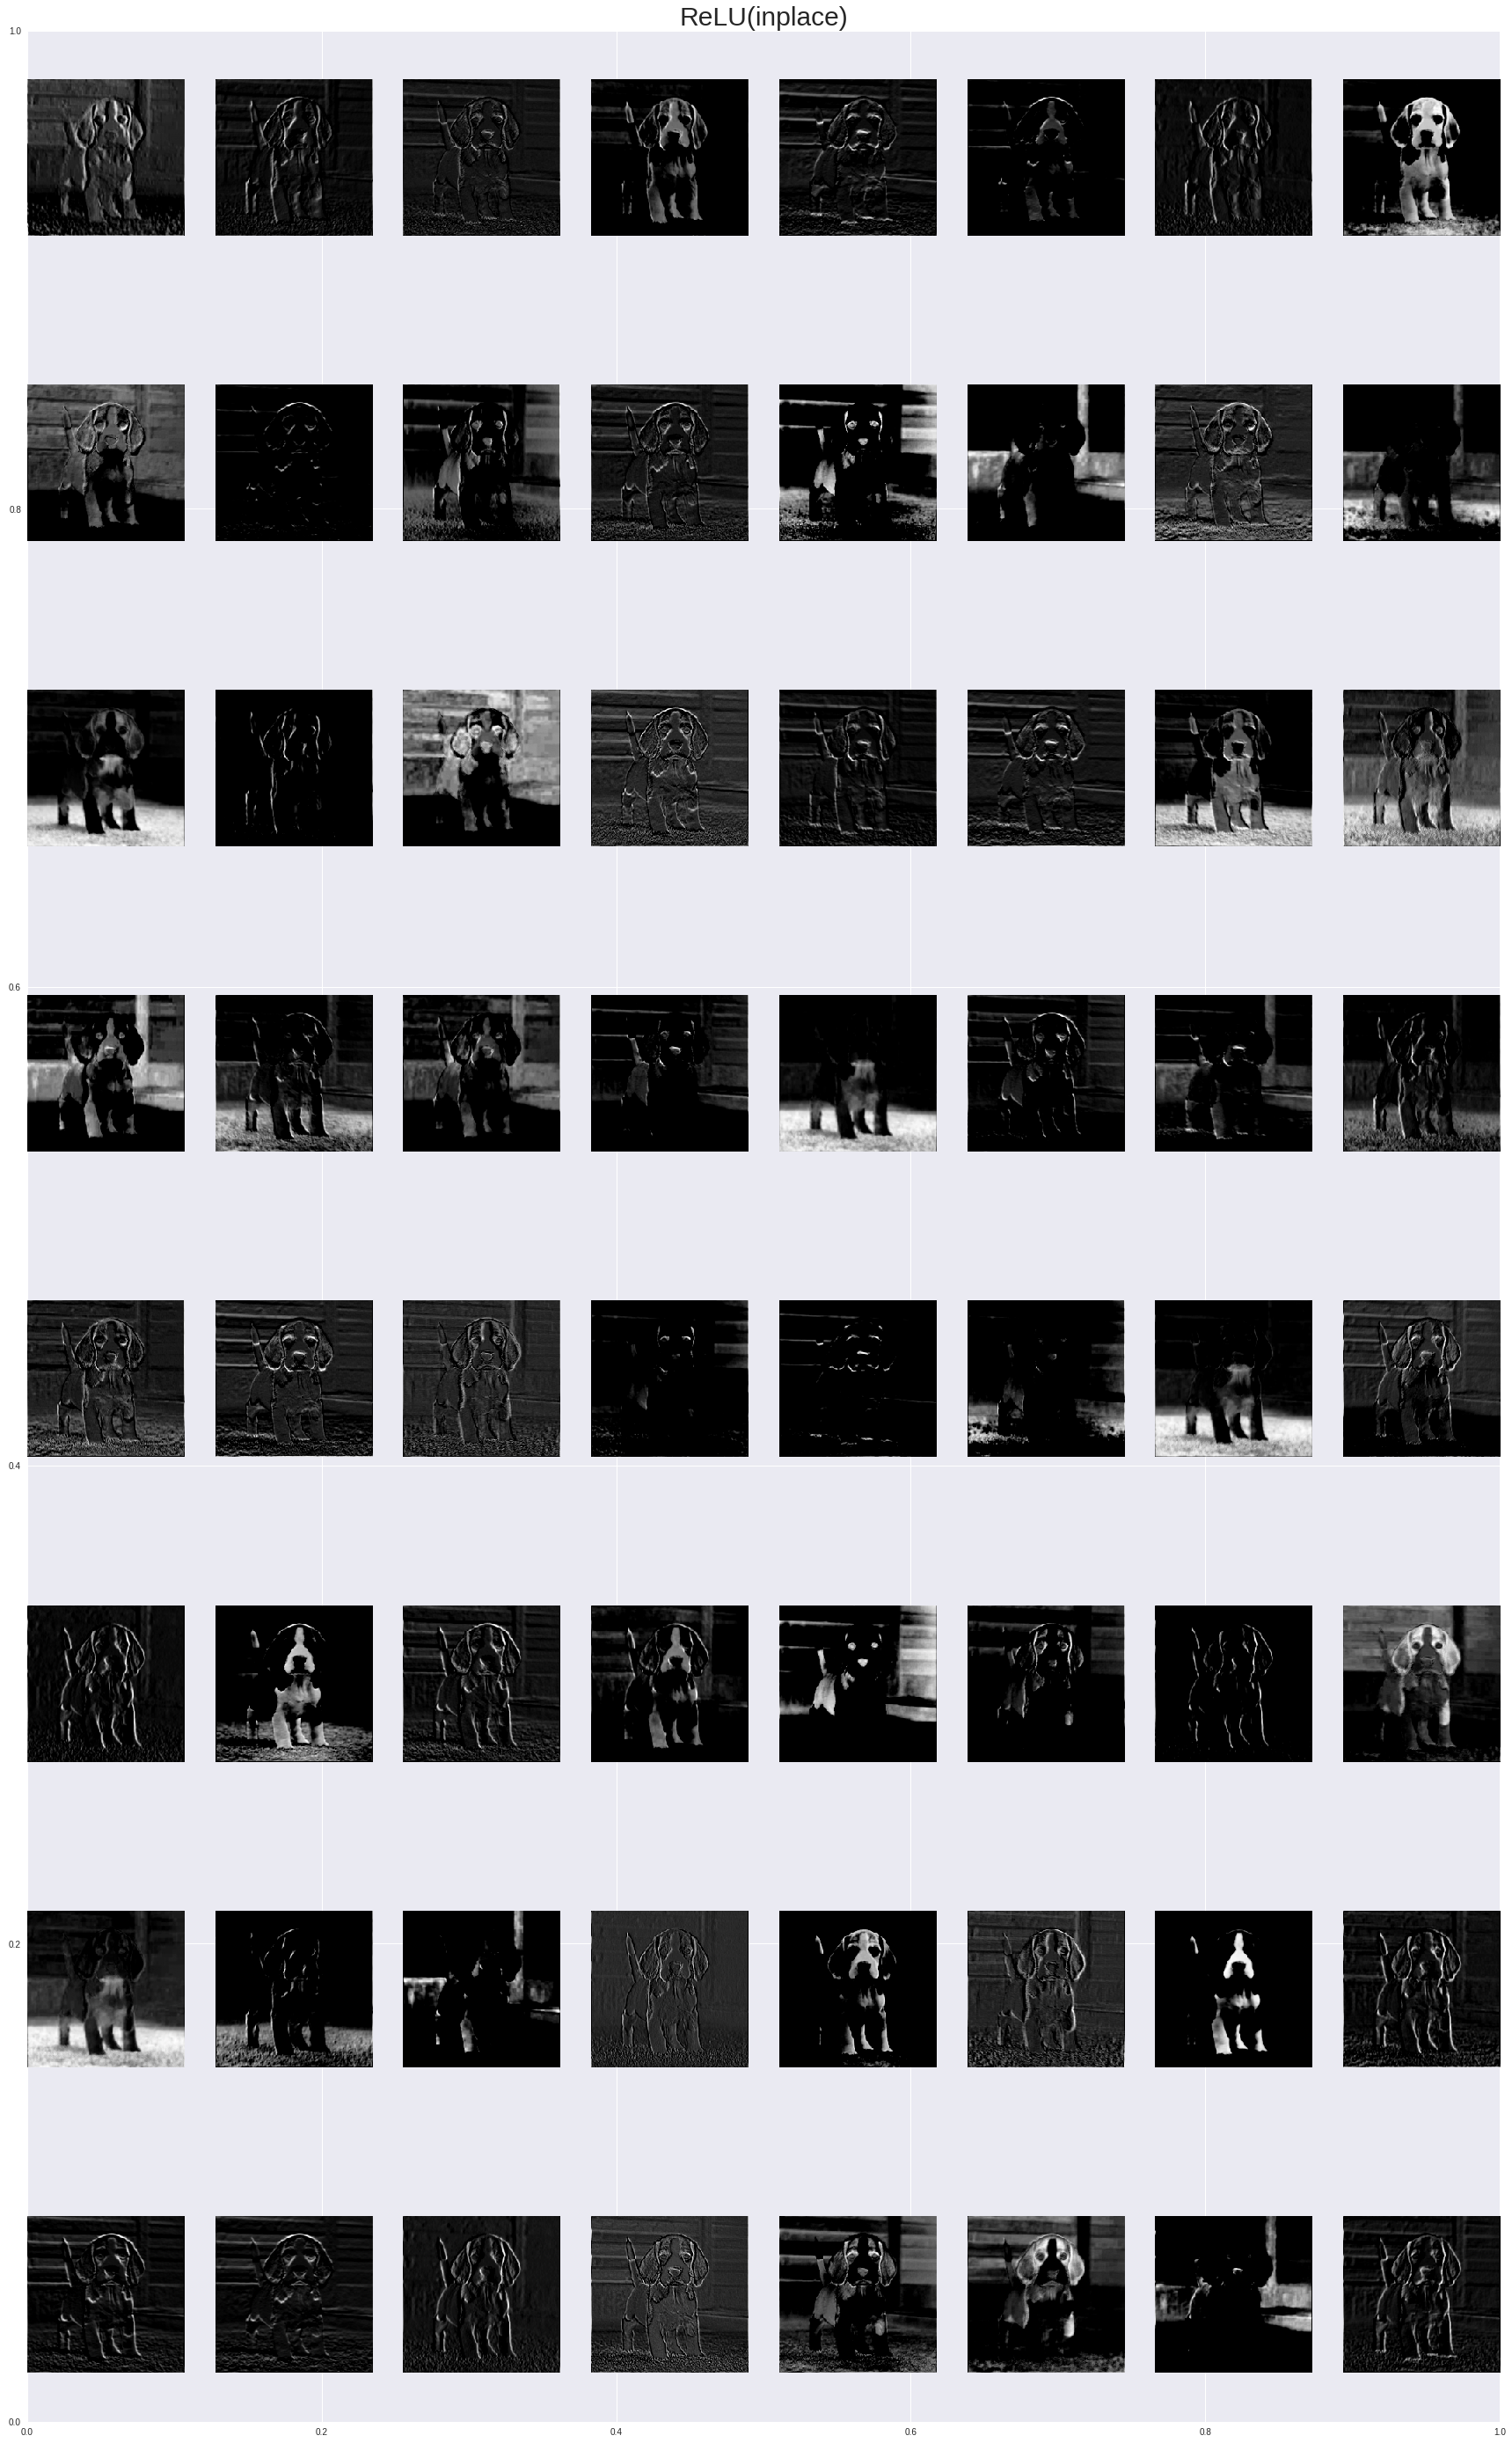

In [161]:
filter_activations(dog, 1)

## Code for Visualizing weights

In [0]:
# visualizing weights: Not very interesting

def visual_features(layer):
  wt_lyr = []
  for w in model.features.children():
    if isinstance(w, torch.nn.modules.conv.Conv2d):
      wt_lyr.append(w.weight.data)
      
  filters = []
  print(wt_lyr[layer].shape)
  for i in range(wt_lyr[layer].shape[0]):
    filters.append(wt_lyr[layer][i,:,:,:].sum(dim=0))
    filters[i].div(wt_lyr[layer].shape[1])
    
  fig = figure()
  rcParams["figure.figsize"]=(10,10)
  for i in range(int(np.sqrt(wt_lyr[layer].shape[0]**2))):
    a = fig.add_subplot(np.sqrt(wt_lyr[layer].shape[0]),np.sqrt(wt_lyr[layer].shape[0]),i+1)
    imshow(filters[i])
    plt.axis('off')
    


## Visualizing Filters/Weights
- VGG is not a very good network to visualize higher layer abstract weights since only so much information can be visualized explicitly with just a 3x3 filter size

torch.Size([64, 64, 3, 3])


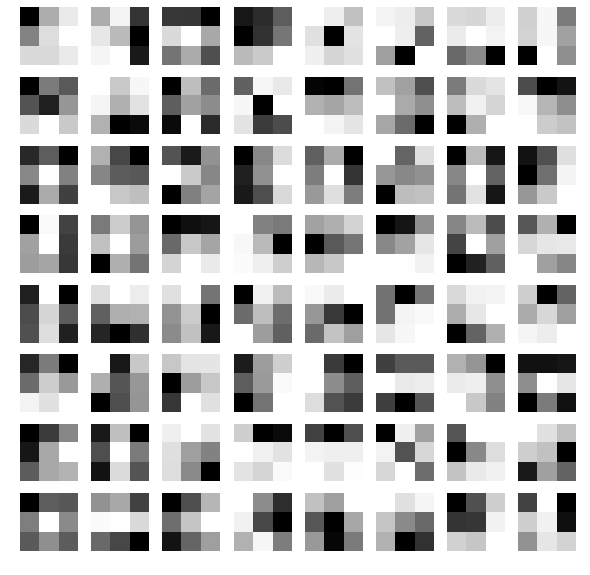

In [178]:
visual_features(1)

## Code for Occlusion

In [0]:
#Occlusion based heatmaps: Awesome!
def make_heatmap(image, true_class, k=8, stride=8):
  heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
  image = image.data
  
  i = 0
  a = 0
  while i<=image.shape[3]-k:
    j=0
    b=0
    while j<=image.shape[2]-k:
      mask = torch.ones(image.shape)
      mask[:,:,j:j+k,i:i+k] = 0
      tmp = Variable((image.cuda() * mask.cuda()).cuda())
      out = model(tmp)
#       print(out.size())
      softmax = nn.functional.softmax(out, dim=1).data[0]
      heatmap[a][b] = softmax[true_class]
      j += stride
      b += 1
#     print(a)
    i += stride
    a += 1
    
  image = image.squeeze()
  
  true_image = image.transpose(0,1)
  true_image = true_image.transpose(1,2)
  
  true_image = postprocess(true_image)
  
  fig = figure()
  rcParams["figure.figsize"] = (1,1)
  axis('off')
  
  fig.add_subplot(1,2,1)
  imshow(true_image)
  title('Orignal Image')
  
  #Normalize Heatmap
  heatmap = heatmap - heatmap.min()
  heatmap = uint8(255 * heatmap)
  print(heatmap.shape)
  fig.add_subplot(1,2,2)
  imshow(1 - heatmap)
  title('Heatmap')
  
  return heatmap
  

('162', 'beagle')

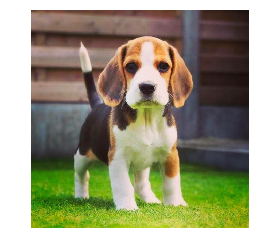

In [9]:
dog = preprocess(load_image('beagle.jpg'))
predict(dog)

>>>>>>>> ## HeatMap by Occlusion

(25, 25)


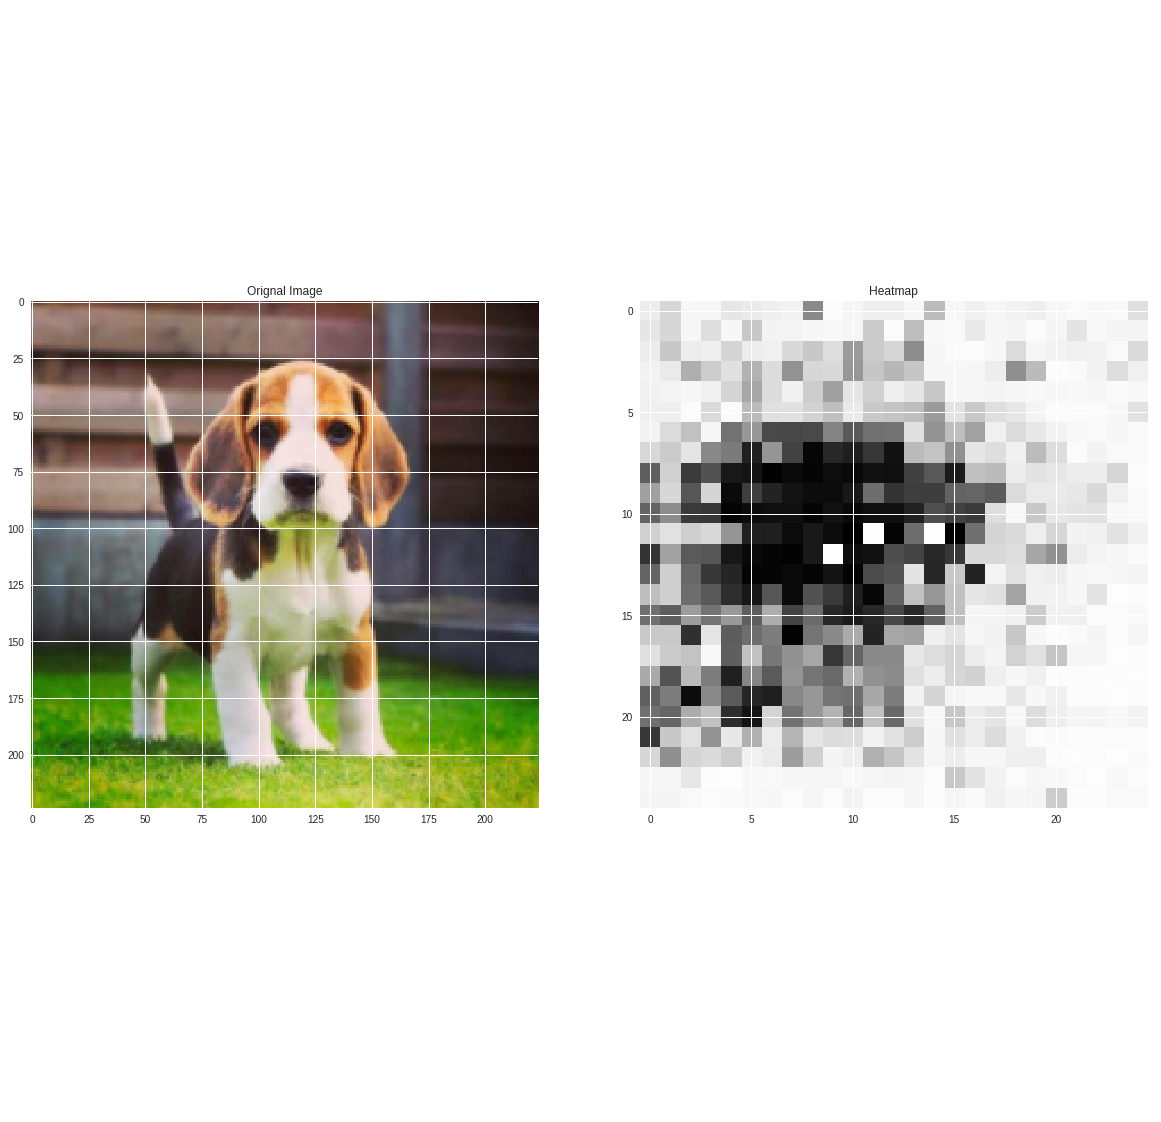

In [65]:
beagle_heatmap = make_heatmap(dog, 162, 100, 5)

## Code for Saliency Maps

In [0]:
# Class specific Saliency Maps

def make_saliency_map(image, label, guided):
  image = Variable(preprocess(image, False).unsqueeze(0).cuda(), requires_grad = True)
  output = model.forward(image)
  output[0][label].backward()
  if guided is True:
    grads = image.grad.data.clamp(min=0)
  else:
    grads = image.grad.data - image.grad.data.min()
  grads.squeeze_()
  grads.transpose_(0,1)
  grads.transpose_(1,2)
  grads = np.amax(grads.cpu().numpy(), axis=2)
  
  true_image = image.data
  true_image.squeeze_()
  true_image.transpose_(0,1)
  true_image.transpose_(1,2)
  true_image = postprocess(true_image)
  
  fig = figure()
  rcParams["figure.figsize"] = (20,20)
  
  a = fig.add_subplot(1,2,1)
  imgplot = imshow(true_image)
  title('Orignal Image')
  axis('off')
  
  a = fig.add_subplot(1,2,2)
  imgplot = imshow(1-grads)
  title('Saliency Map')
  axis('off')
  
  return grads
  
  

>>>>>>>>>> ## Saliency Maps (Simple Bckprop)

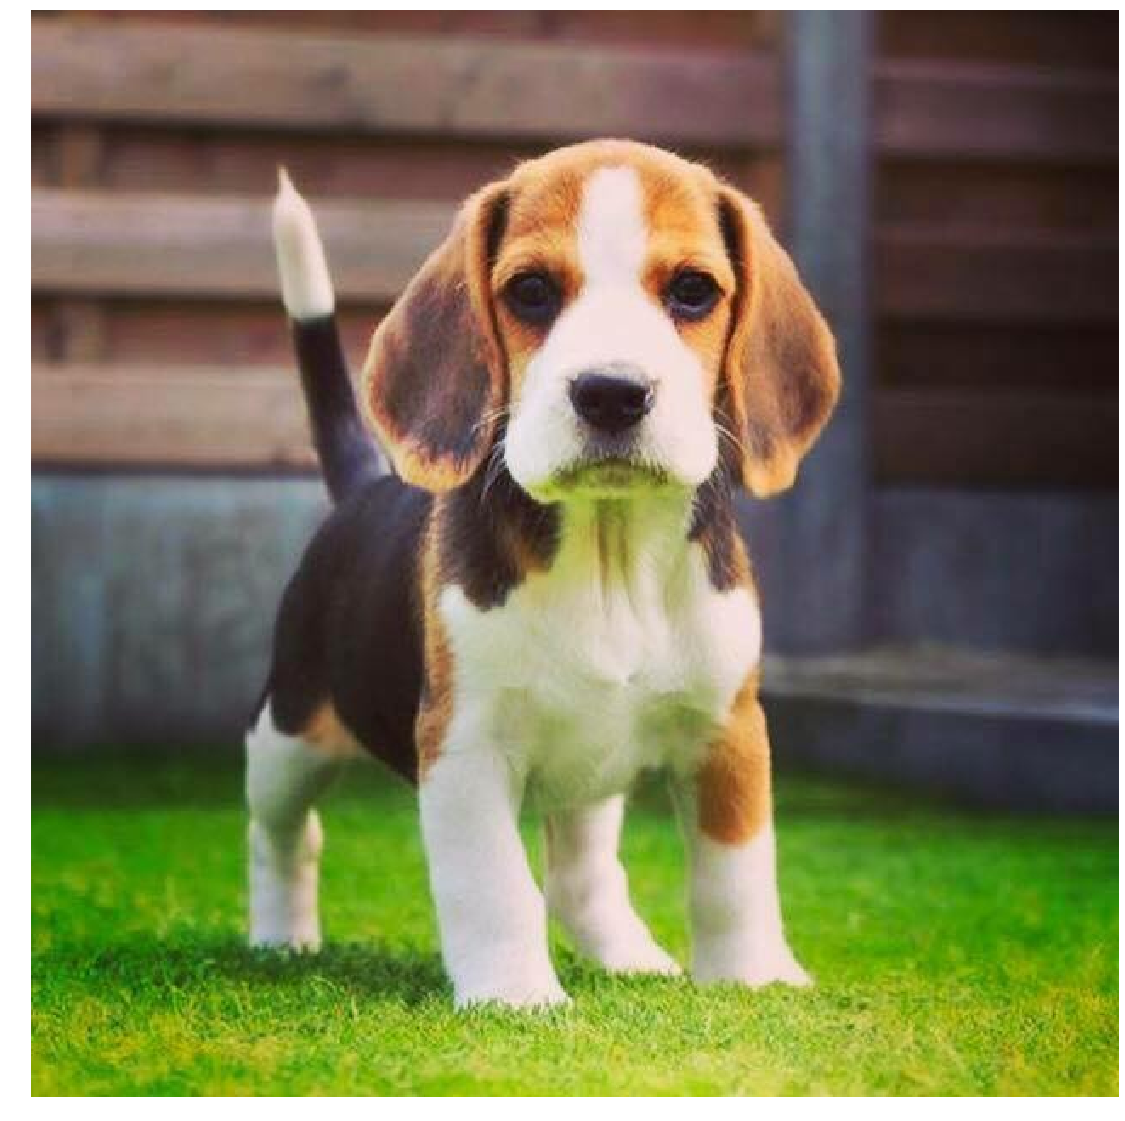

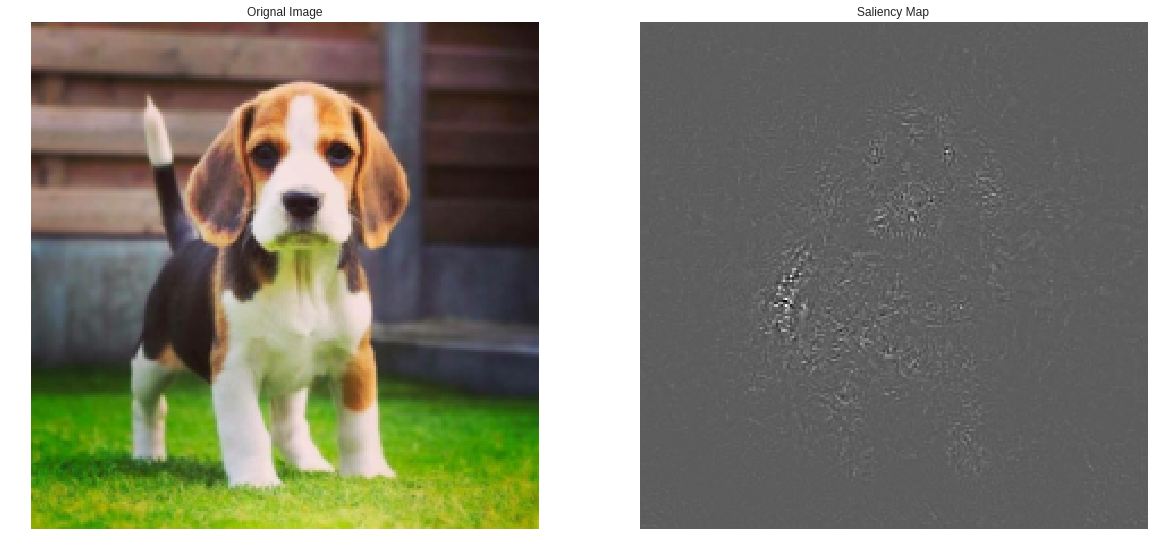

In [161]:
dog = load_image('beagle.jpg')
dog_sal = make_saliency_map(dog, 162, False)

>> >> >> ## (Guided Backprop)

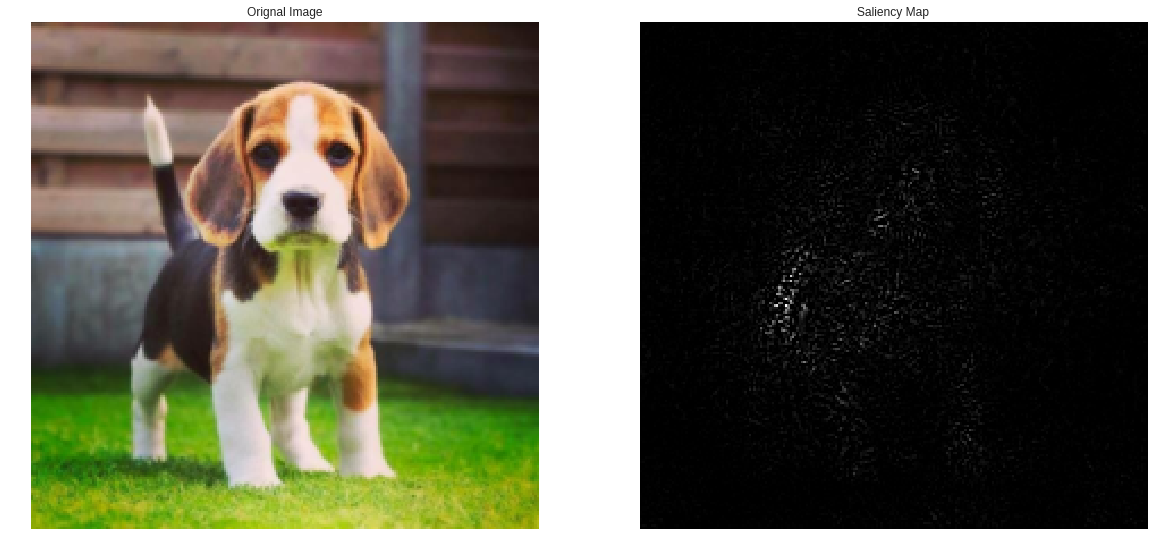

In [108]:
dog_sal = make_saliency_map(dog, 162, True)

- So a beagle's bum produces more activation rather than it's droopy ears or the cute face? VGG might be good for accuracy but representations and their semantic meaning are no match to Inception!

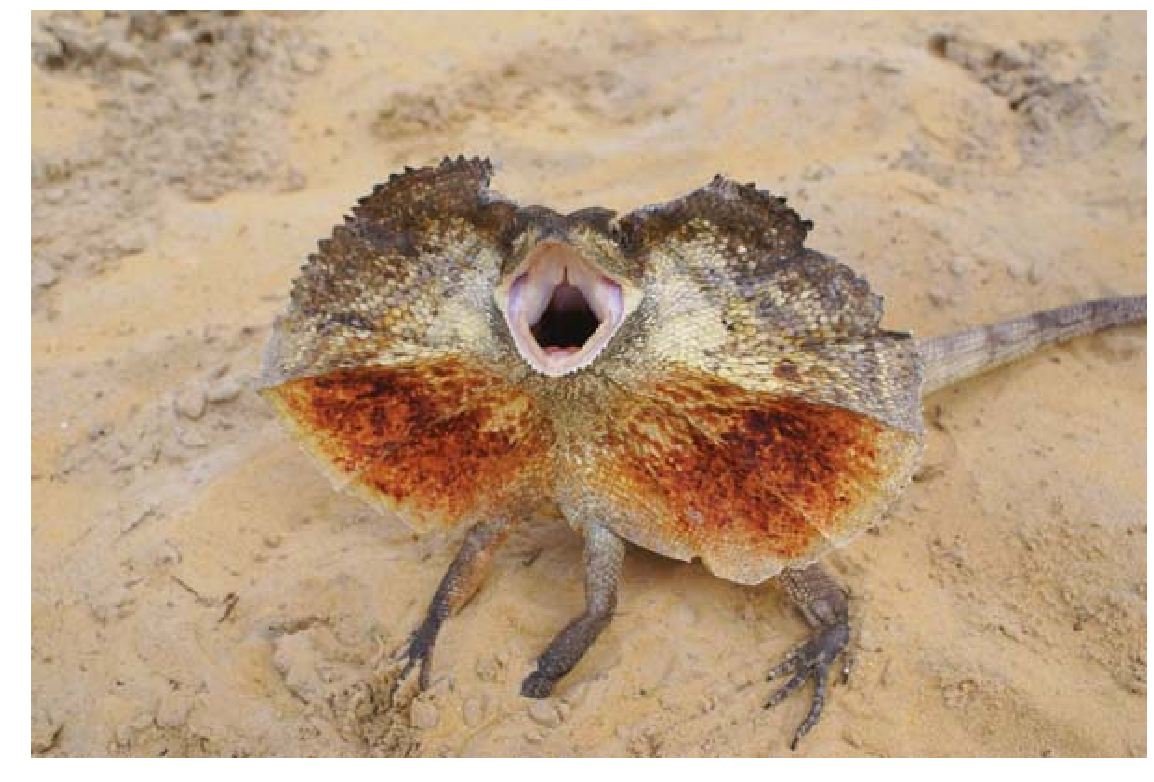

In [27]:
liz = load_image('Frilled7.jpg')


In [34]:
lizproc = print(predict(preprocess(liz)))

('43', 'frilled_lizard')


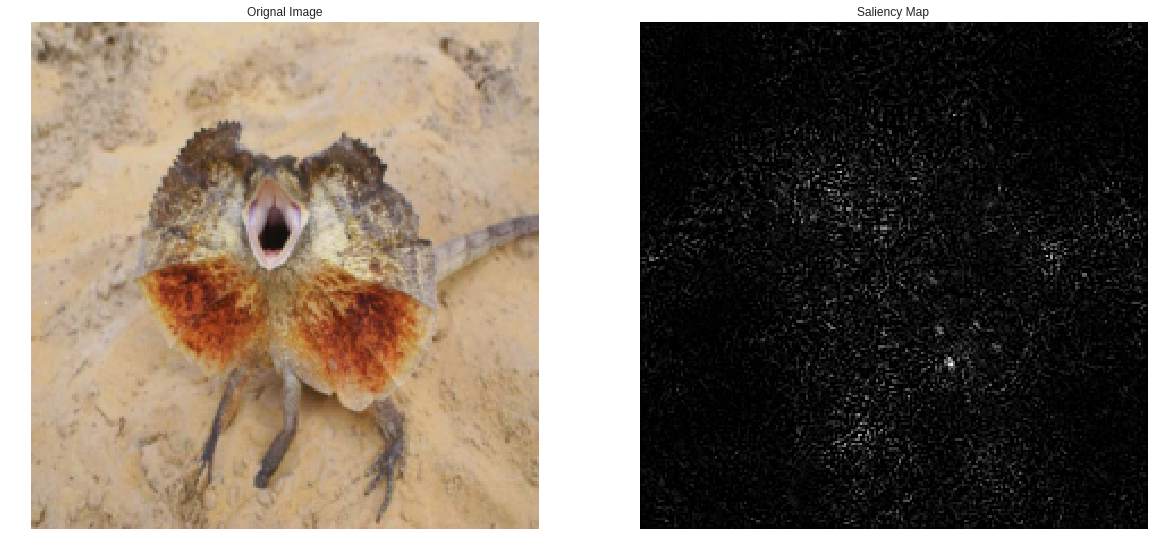

In [22]:
sal_liz = make_saliency_map(liz, 43)

## Code for SmoothGrad

- Clipping gradients after averaging.

In [0]:
def smooth_grad(img, label, samples=10, noise_lvl=10, clip_after=True):

  """ 
  Removing Noise by adding noise
  Basically we add gaussian noise to the orignal image to generate new samples and then average their saliency/sensitivity maps to remove the noise

  """
#   print(img.dtype)
  image = torch.from_numpy(img).type(torch.cuda.FloatTensor)
  
  accumulated = torch.zeros((1,3,224,224)).cuda()
  std_dev = (noise_lvl/100)*(image.max()-image.min())
  dim = image.size()
  for i in range(samples):
#     print('Sample: ', i+1)
    temp = image
    # Gaussian matrix of image size, stddev = noise/100*(max-min_pixel_value)
    noise = torch.from_numpy(np.random.normal(loc=0, scale=std_dev, size=dim)).type(torch.cuda.FloatTensor)
    temp = (temp+noise).type(torch.uint8).cpu().numpy()
#     print(temp.dtype)
    temp = Variable(preprocess(temp, x=False).unsqueeze(0).cuda(), requires_grad=True)
    
    out = model.forward(temp)
    out[0][label].backward()
    temp = temp.grad.data

    if not clip_after:
      mask = -(temp >= 0.01) + (temp<= -0.01)
      temp *= mask.type(torch.cuda.FloatTensor)
      
#       temp = temp.clamp(max=0)
      accumulated += temp
      
    else:
      accumulated += temp*temp


  grads = accumulated/samples
    

#     statement = (grads == grads.clamp(min=0)).min()
#     print(statement)
#     grads = grads.clamp(min=0)
  
  grads.squeeze_()
  grads.transpose_(0,1)
  grads.transpose_(1,2)
  grads = np.amax(grads.cpu().numpy(), axis=2)
#   print(grads.shape)
  fig = figure()
  rcParams["figure.figsize"] = (20,20)
  axis("off")
  _ = fig.add_subplot(1,2,1)
  _ = imshow(img)
  title("Orignal Image")
  
  
  _ = fig.add_subplot(1,2,2)
  _ = imshow(1-grads)
  plt.title('SmoothGrad, Noise:{}, Iterations:{}'.format(noise_lvl, samples))
  
  
  return grads
  

## Smooth Grad

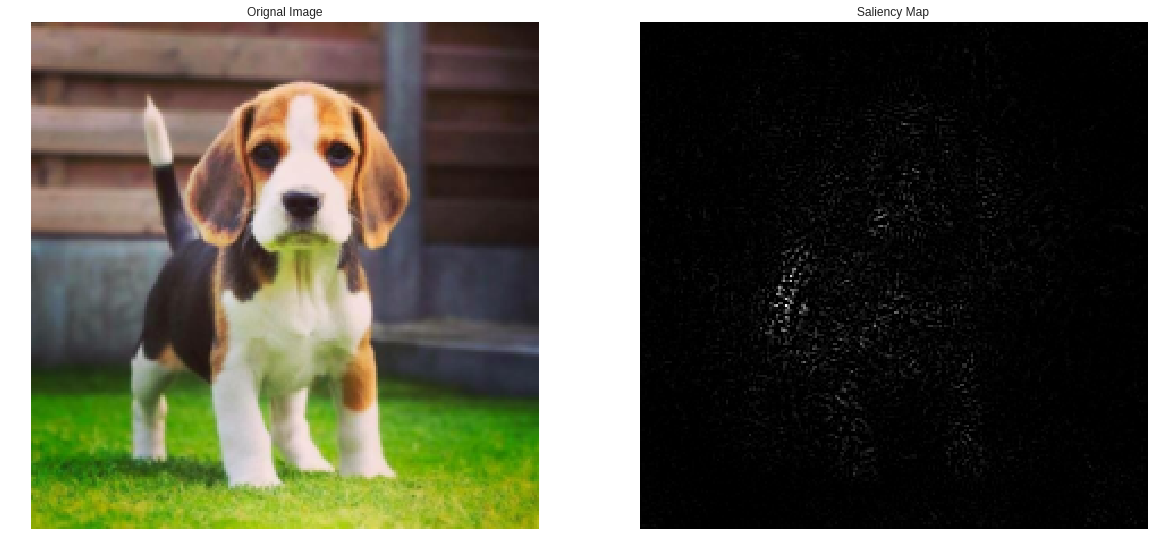

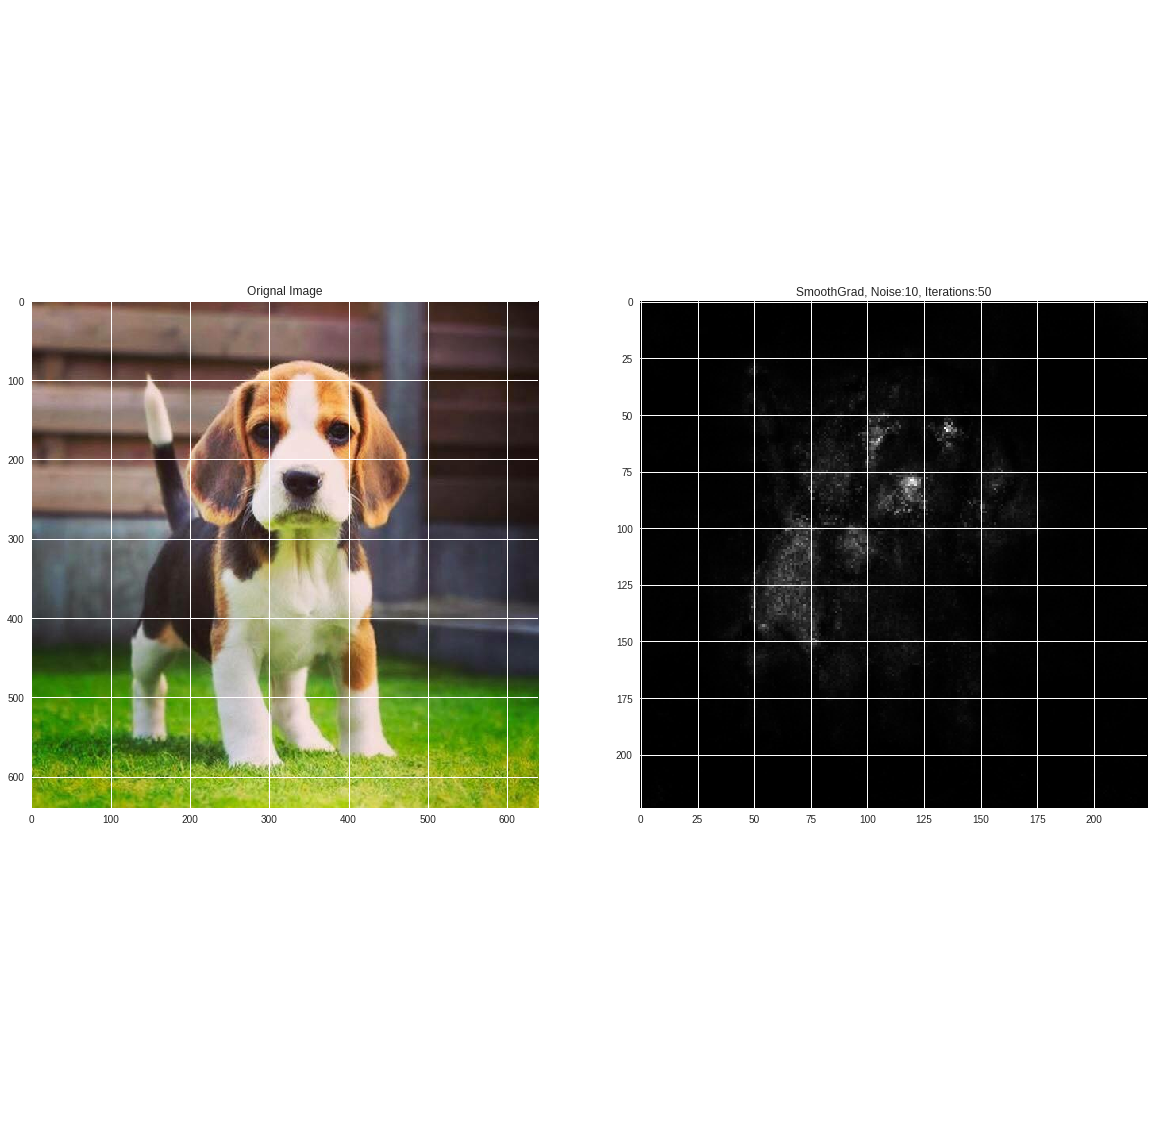

In [174]:
_ = make_saliency_map(dog, 162, True)
g1 = smooth_grad(dog, 162, 50, 10, True) # 50 iterations with 10 percent Noise
# g2 = smooth_grad(dog, 162, 50, 10, False)

- According to the paper, while 10-20% noise level seems to give good results on Inception, the ideal noise level depends on the Input.
Example - MNIST performs good with 75% Noise